## Connect to Google Drive to download JSON file with preprocessed data

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Load data from preprocessed JSON

In [2]:
import json

def load_data(json_path):
  with open(json_path, "r") as fp:
        data = json.load(fp)

  X = (data['mfcc']) # Contains name of the song and corresponding MFCC's
  y = (data['labels']) # Contains genre labels of each song
  return X, y

json_path = '/content/drive/MyDrive/DL/Project/Data/preprocess/mel_specs.json'
orig_x_data, orig_y_data = load_data(json_path)

## Refactor data into numpy array of spectrograms

In [3]:
import numpy as np
import sys

x_data, y_data = [], []
for i in range(len(orig_x_data)):
  x_d = orig_x_data[i]
  for j in range(len(x_d)):
    x_data.append([x_d[j][0][0], np.array(x_d[j][1]).T])
    y_data.append(orig_y_data[i])
X = x_data
y = np.array(y_data)

## Split data into train and test sets

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Divide data into pairs

In [5]:
def create_pairs(plots, labels):
  pair_plots, pair_labels, pair_names = [], [], []
  num_labels = len(np.unique(labels)) # number of labels
  
  # Get indices of songs of each genre
  indices = [np.where(labels == i)[0] for i in range(num_labels)]
  
  for idx1 in range(len(plots)):
    # Get the current song name, MFCC and genre
    name1 = plots[idx1][0]
    plot1 = plots[idx1][1]
    label1 = labels[idx1]

    # Take random MFCC of other song with the same genre
    idx2 = np.random.choice(indices[label1])
    name2 = plots[idx2][0]
    plot2 = plots[idx2][1]

    # Add pair
    pair_plots.append([plot1, plot2])
    pair_labels.append([1])
    pair_names.append([name1, name2])

    # Take random MFCC of other song with different genre
    idx3 = np.where(labels != label1)[0]
    rand_idx3 = np.random.choice(idx3)
    name3 = plots[rand_idx3][0]
    plot3 = plots[rand_idx3][1]

    # Add pair
    pair_plots.append([plot1, plot3])
    pair_labels.append([0])
    pair_names.append([name1, name3])
  return np.array(pair_plots), np.array(pair_labels), pair_names

tr_pairs, tr_y, tr_names = create_pairs(X_train, y_train)
ts_pairs, ts_y, ts_names = create_pairs(X_test, y_test)

## Initialize network

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

def initialize_base_network(input_shape, embeddingDim=48):
    input = Input(shape=input_shape, name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(256, activation='sigmoid', name="first_base_dense")(x)
    x = Dense(256, activation='sigmoid', name="second_base_dense")(x)
    x = Dense(256, activation='sigmoid', name="third_base_dense")(x)

    model = Model(inputs=input, outputs=x)
    print(model.summary())
    return model

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [23]:
shape = (13,130,1)
base_network = initialize_base_network(input_shape=shape)
# Create the left input and point to the base network
input_a = Input(shape=shape, name="left_input")
vect_output_a = base_network(input_a)

# Create the right input and point to the base network
input_b = Input(shape=shape, name="right_input")
vect_output_b = base_network(input_b)

# Measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# Specify the inputs and output of the model
model = Model([input_a, input_b], output)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_input (InputLayer)     [(None, 13, 130, 1)]      0         
                                                                 
 flatten_input (Flatten)     (None, 1690)              0         
                                                                 
 first_base_dense (Dense)    (None, 256)               432896    
                                                                 
 second_base_dense (Dense)   (None, 256)               65792     
                                                                 
 third_base_dense (Dense)    (None, 256)               65792     
                                                                 
Total params: 564,480
Trainable params: 564,480
Non-trainable params: 0
_________________________________________________________________
None


### Single network representation

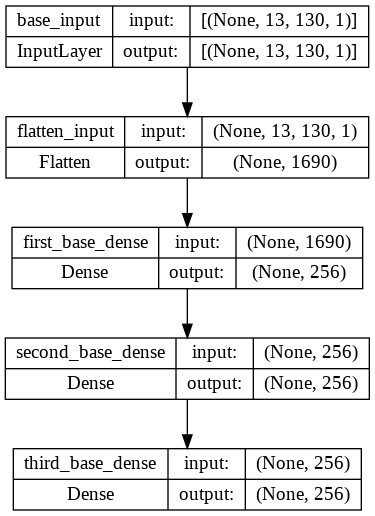

In [8]:
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

### Siamese netowrk representation

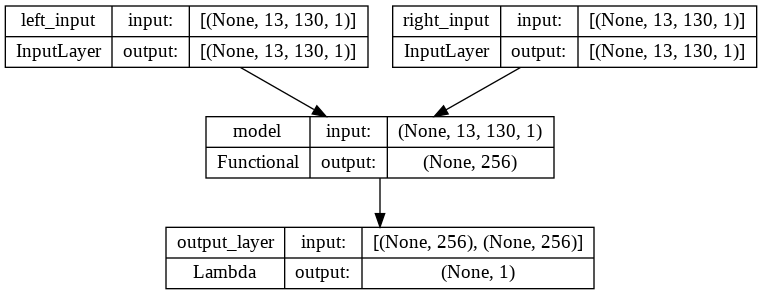

In [9]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

## Train model

In [25]:
opt = Adam()
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=500, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_input (InputLayer)     [(None, 13, 130, 1)]      0         
                                                                 
 flatten_input (Flatten)     (None, 1690)              0         
                                                                 
 first_base_dense (Dense)    (None, 256)               432896    
                                                                 
 second_base_dense (Dense)   (None, 256)               65792     
                                                                 
 third_base_dense (Dense)    (None, 256)               65792     
                                                                 
Total params: 564,480
Trainable params: 564,480
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
110/110 [===========================

## Compute accuracy

In [11]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.3
    return np.mean(pred == y_true)

In [26]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

188/188 [==============================] - 0s 2ms/step
Loss = [0.2858554720878601, 0.5026702284812927], Train Accuracy = 0.5 Test Accuracy = 0.5


## Plot training results

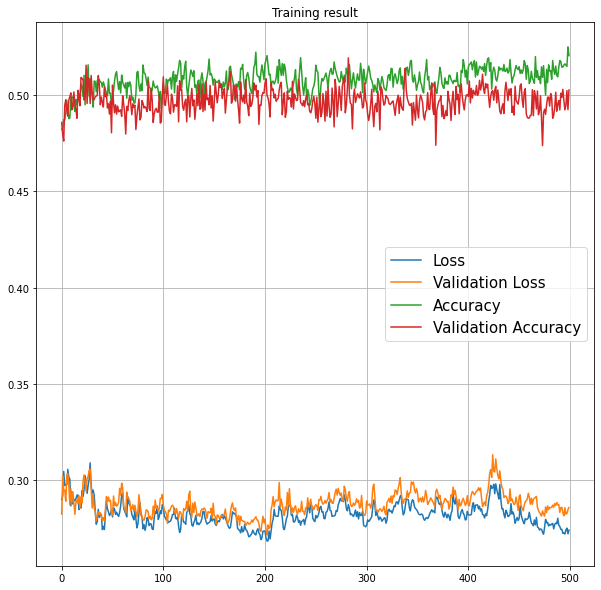

In [27]:
import matplotlib.pyplot as plt

def plot_metrics(title="Training result"):
    fig, ax = plt.subplots(figsize=((10, 10)))
    ax.set_title(title)
    ax.plot(history.history['loss'], label="Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.plot(history.history['accuracy'], label="Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.grid()
    ax.legend(prop={'size': 15})

plot_metrics()

## Display the most and the least similar song from training

Text(0.5, 1.0, 'Song is pop.00055.wav')

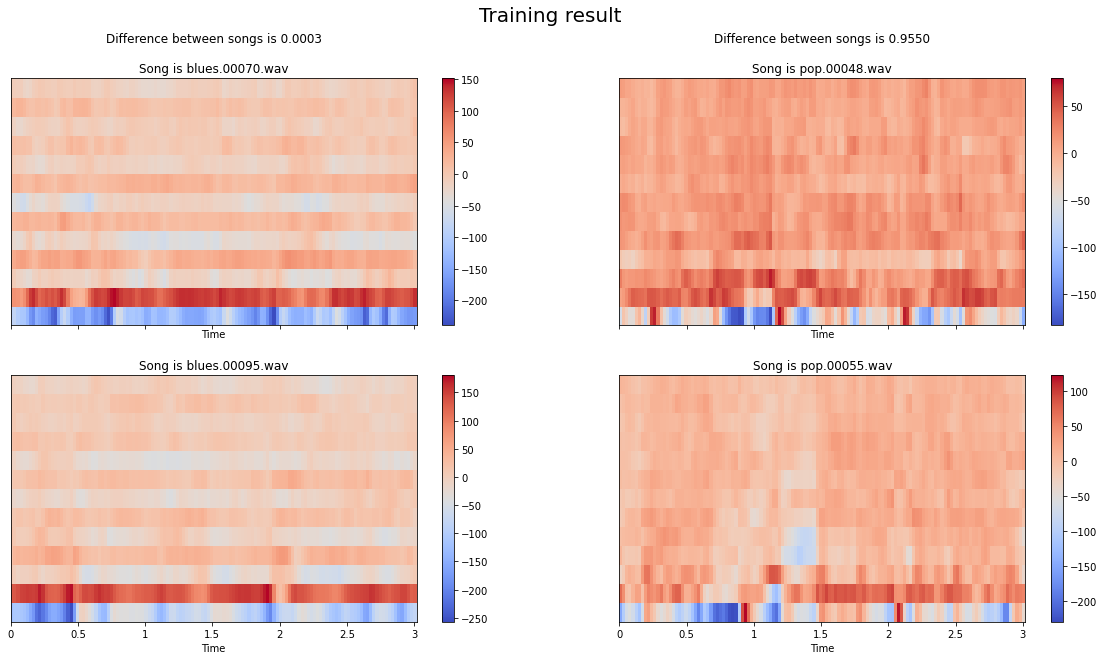

In [29]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

min_dif = np.min(y_pred_train)
min_ind = np.where(y_pred_train == min_dif)[0][0]
max_dif = np.max(y_pred_train)
max_ind = np.where(y_pred_train == max_dif)[0][0]

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(20, 10))
fig.suptitle("Training result", fontsize=20)
img0 = librosa.display.specshow(tr_pairs[min_ind,0], x_axis="time", ax=ax[0,0])
fig.colorbar(img0, ax=[ax[0,0]])
ax[0,0].set_title(f"Difference between songs is {min_dif:.4f}\n\nSong is {tr_names[min_ind][0]}")

img1 = librosa.display.specshow(tr_pairs[min_ind,1], x_axis='time', ax=ax[1,0])
fig.colorbar(img1, ax=[ax[1,0]])
ax[1,0].set_title(f"Song is {tr_names[min_ind][1]}")

img2 = librosa.display.specshow(tr_pairs[max_ind,0], x_axis='time', ax=ax[0,1])
fig.colorbar(img2, ax=[ax[0,1]])
ax[0,1].set_title(f"Difference between songs is {max_dif:.4f}\n\nSong is {tr_names[max_ind][0]}")

img3 = librosa.display.specshow(tr_pairs[max_ind,1], x_axis='time', ax=ax[1,1])
fig.colorbar(img3, ax=[ax[1,1]])
ax[1,1].set_title(f"Song is {tr_names[max_ind][1]}")

## Display the most and the least similar song from test

Text(0.5, 1.0, 'Song is jazz.00092.wav')

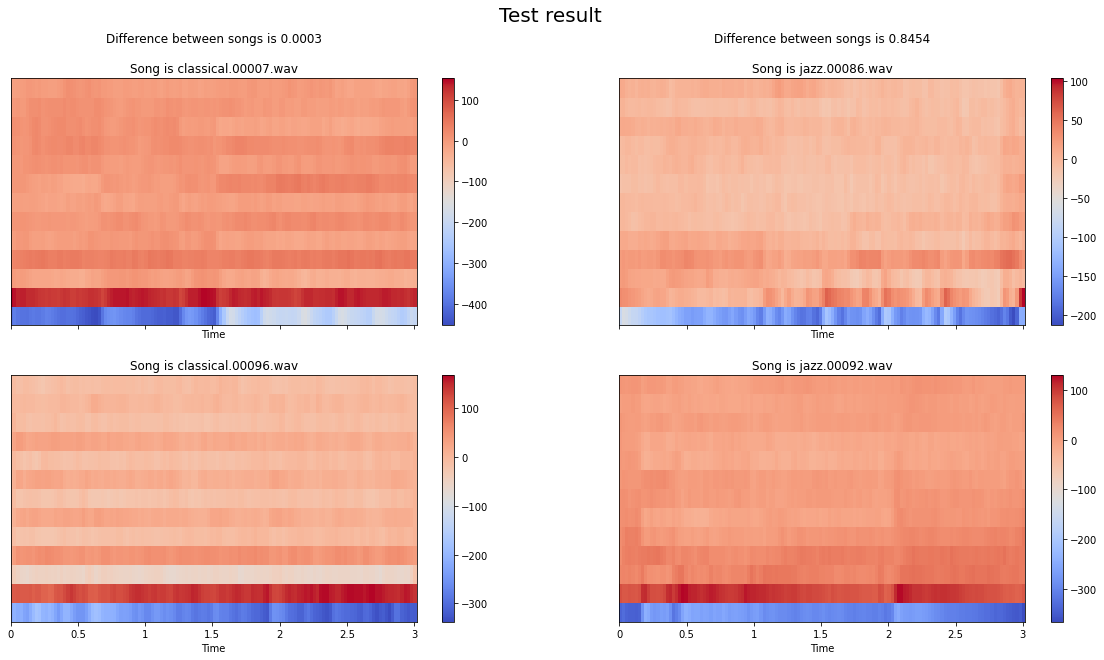

In [30]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

min_dif = np.min(y_pred_test)
min_ind = np.where(y_pred_test == min_dif)[0][0]
max_dif = np.max(y_pred_test)
max_ind = np.where(y_pred_test == max_dif)[0][0]

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(20, 10))
fig.suptitle("Test result", fontsize=20)
img0 = librosa.display.specshow(ts_pairs[min_ind,0], x_axis="time", ax=ax[0,0])
fig.colorbar(img0, ax=[ax[0,0]])
ax[0,0].set_title(f"Difference between songs is {min_dif:.4f}\n\nSong is {ts_names[min_ind][0]}")

img1 = librosa.display.specshow(ts_pairs[min_ind,1], x_axis='time', ax=ax[1,0])
fig.colorbar(img1, ax=[ax[1,0]])
ax[1,0].set_title(f"Song is {ts_names[min_ind][1]}")

img2 = librosa.display.specshow(ts_pairs[max_ind,0], x_axis='time', ax=ax[0,1])
fig.colorbar(img2, ax=[ax[0,1]])
ax[0,1].set_title(f"Difference between songs is {max_dif:.4f}\n\nSong is {ts_names[max_ind][0]}")

img3 = librosa.display.specshow(ts_pairs[max_ind,1], x_axis='time', ax=ax[1,1])
fig.colorbar(img3, ax=[ax[1,1]])
ax[1,1].set_title(f"Song is {ts_names[max_ind][1]}")

## Save pretrained model

In [28]:
model.save('/content/drive/MyDrive/DL/Project/Model')

## Make recommendations

In [31]:
def recommendation_list(song_name, num_songs=10):
  fav_song = song_name
  fav_pairs = [[np.array([0]), [fav_song, fav_song]]]
  for i in range(len(tr_names)):
    if (fav_song == tr_names[i][0]) ^ (fav_song == tr_names[i][1]):
      fav_pairs.append([y_pred_train[i], tr_names[i]])
  for i in range(len(ts_names)):
    if (fav_song == ts_names[i][0]) ^ (fav_song == ts_names[i][1]):
      fav_pairs.append([y_pred_test[i], ts_names[i]])
  fav_pairs = sorted(fav_pairs, key=lambda l:l[0])
  recommended_list = [pair[1][0] if pair[1][0] != fav_song else pair[1][1] for pair in fav_pairs[:num_songs]]
  return recommended_list

In [32]:
recommendation_list('metal.00024.wav')

['metal.00024.wav',
 'metal.00077.wav',
 'pop.00066.wav',
 'rock.00017.wav',
 'metal.00004.wav',
 'metal.00070.wav',
 'blues.00047.wav',
 'pop.00014.wav',
 'classical.00068.wav',
 'hiphop.00004.wav']